In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

inspired by https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb and
https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb and https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
np.sqrt(800)

28.284271247461902

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


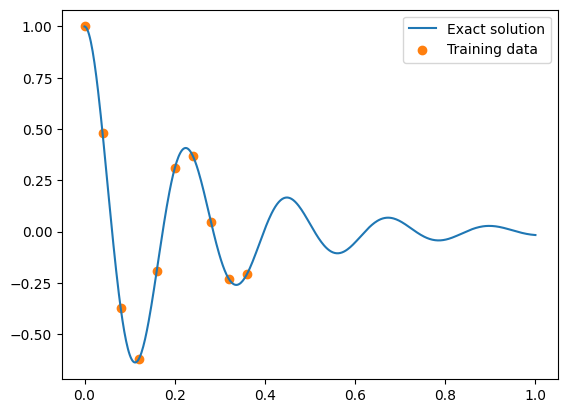

In [4]:
d, w0 = 4, np.sqrt(800)

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [5]:
class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


tensor(0.6264, grad_fn=<MeanBackward0>) tensor(1627.1261, grad_fn=<MeanBackward0>) tensor(0.1760, grad_fn=<MeanBackward0>)


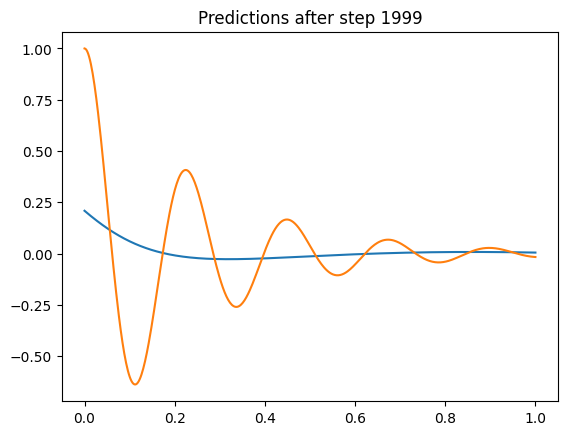

tensor(0.0811, grad_fn=<MeanBackward0>) tensor(1670.9679, grad_fn=<MeanBackward0>) tensor(0.0602, grad_fn=<MeanBackward0>)


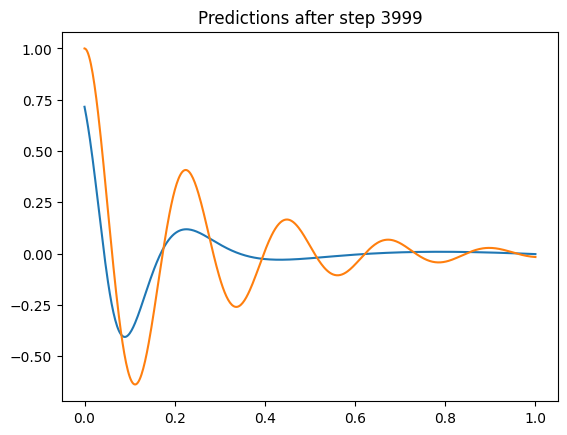

tensor(0.0020, grad_fn=<MeanBackward0>) tensor(528.8095, grad_fn=<MeanBackward0>) tensor(0.0070, grad_fn=<MeanBackward0>)


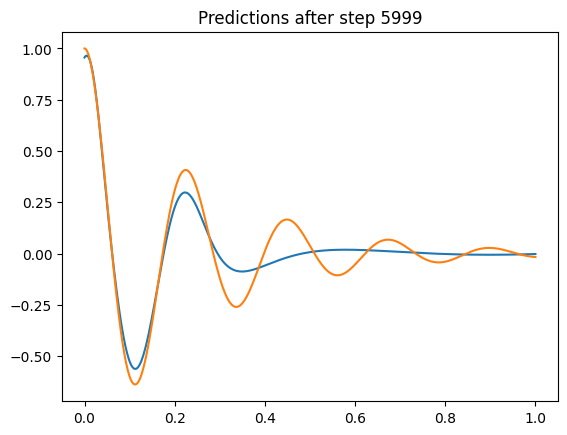

tensor(0.0005, grad_fn=<MeanBackward0>) tensor(368.1089, grad_fn=<MeanBackward0>) tensor(0.0053, grad_fn=<MeanBackward0>)


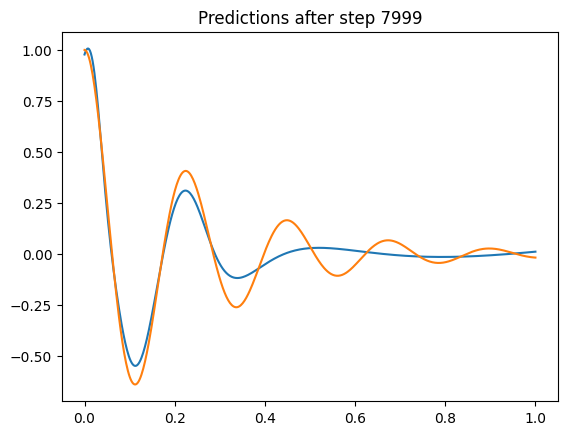

tensor(3.0306e-07, grad_fn=<MeanBackward0>) tensor(126.1208, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)


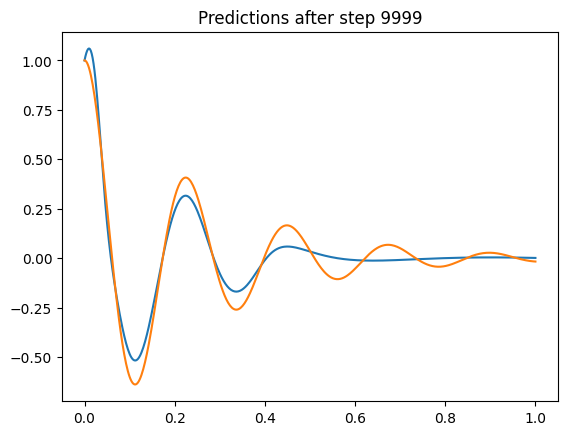

tensor(1.0437e-05, grad_fn=<MeanBackward0>) tensor(87.4916, grad_fn=<MeanBackward0>) tensor(0.0025, grad_fn=<MeanBackward0>)


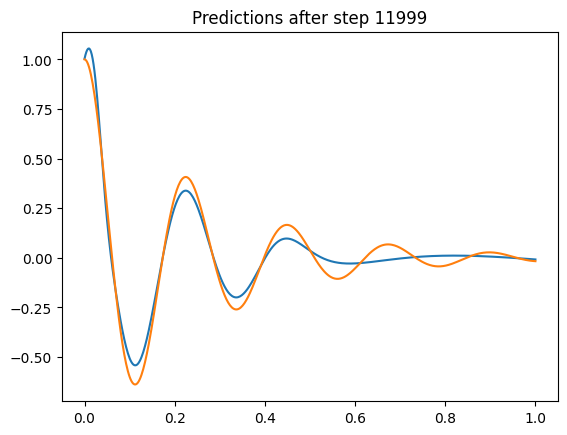

tensor(3.4106e-06, grad_fn=<MeanBackward0>) tensor(80.2123, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)


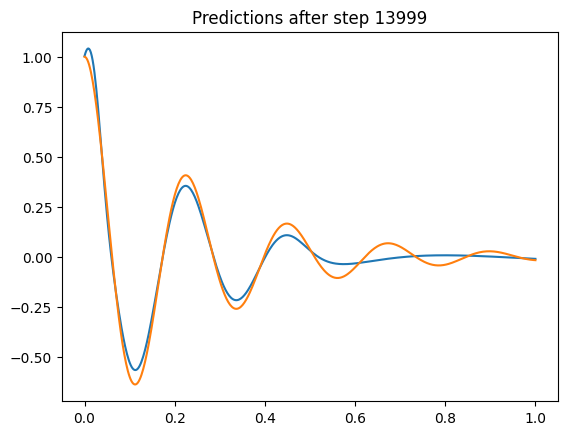

tensor(1.5516e-06, grad_fn=<MeanBackward0>) tensor(73.5592, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)


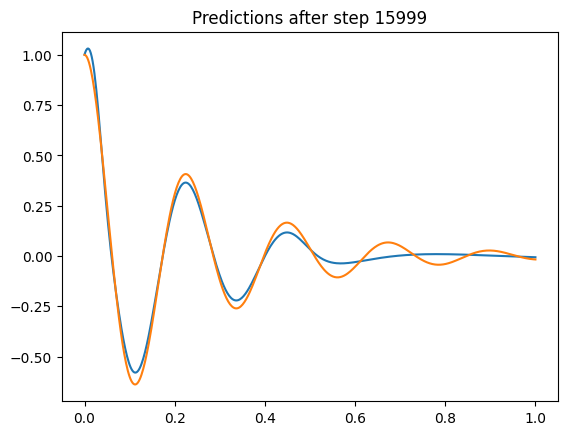

tensor(8.4191e-07, grad_fn=<MeanBackward0>) tensor(69.4231, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)


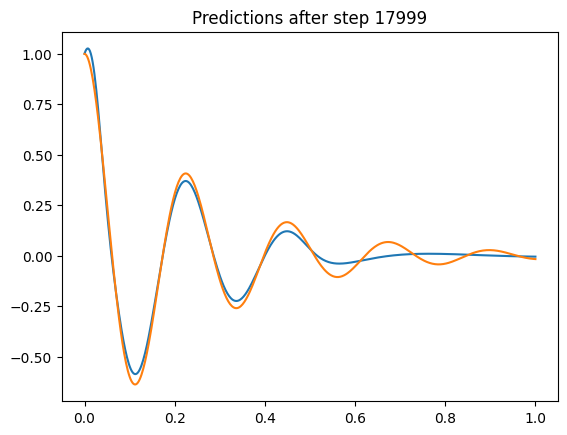

tensor(6.4844e-09, grad_fn=<MeanBackward0>) tensor(64.4065, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)


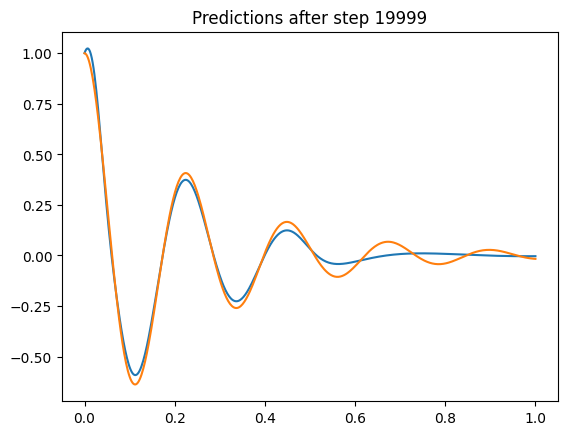

tensor(2.1075e-07, grad_fn=<MeanBackward0>) tensor(59.4993, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)


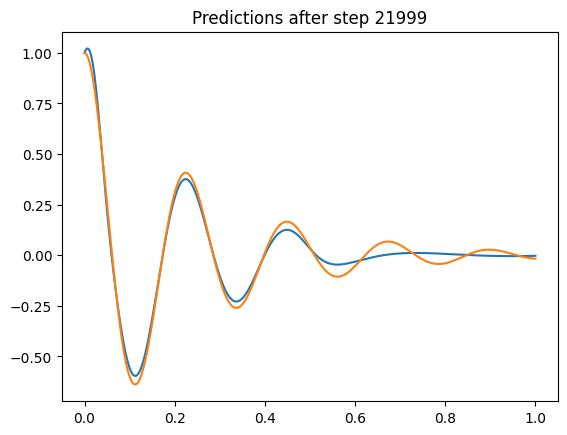

tensor(1.1494e-07, grad_fn=<MeanBackward0>) tensor(55.9458, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)


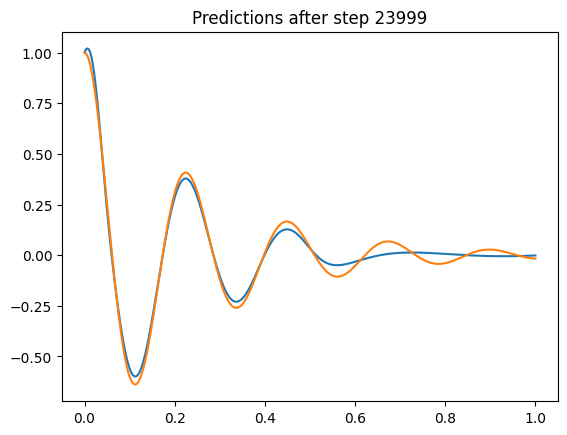

tensor(8.1446e-08, grad_fn=<MeanBackward0>) tensor(52.6276, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)


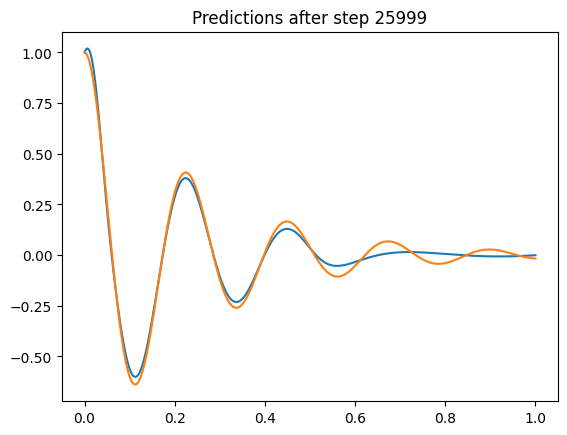

tensor(1.3940e-07, grad_fn=<MeanBackward0>) tensor(48.5565, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)


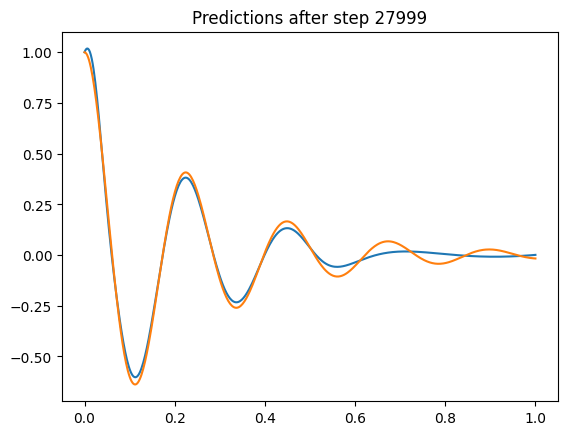

tensor(2.4782e-07, grad_fn=<MeanBackward0>) tensor(44.1578, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)


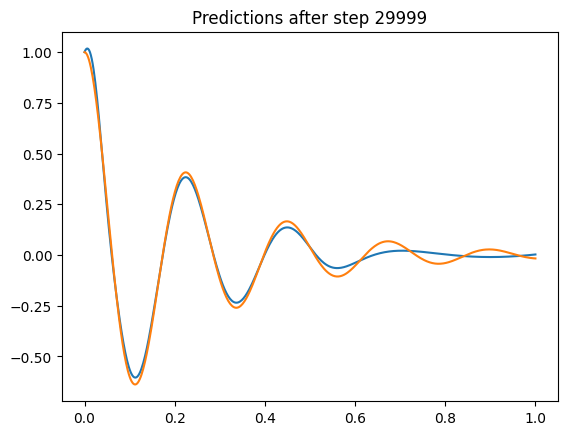

tensor(2.6755e-07, grad_fn=<MeanBackward0>) tensor(41.7067, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)


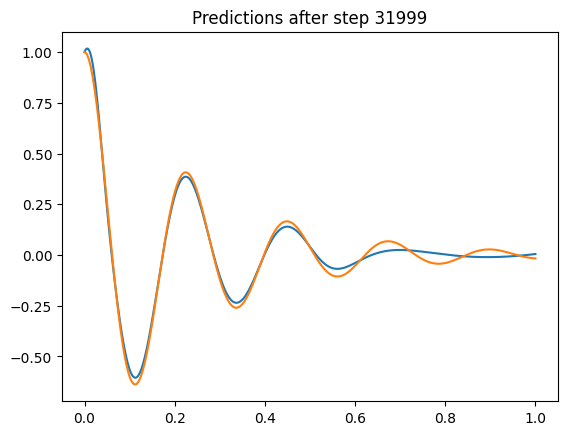

tensor(4.3223e-07, grad_fn=<MeanBackward0>) tensor(38.6683, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)


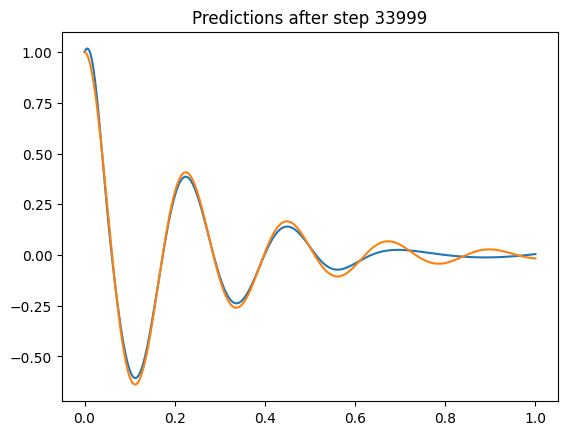

tensor(1.5724e-06, grad_fn=<MeanBackward0>) tensor(36.7331, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)


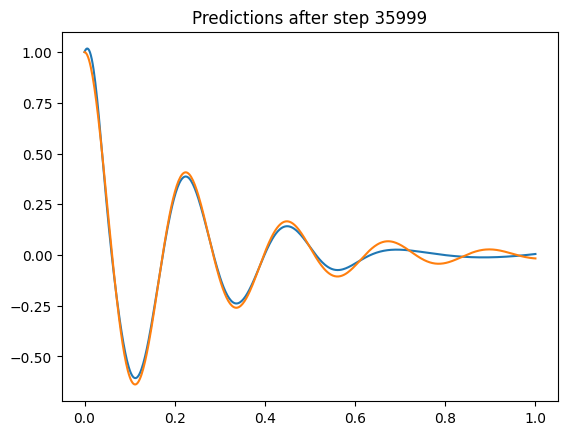

tensor(6.1753e-07, grad_fn=<MeanBackward0>) tensor(34.9884, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)


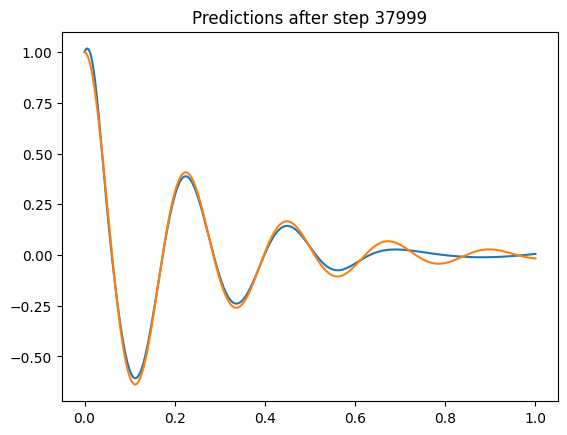

tensor(7.9702e-07, grad_fn=<MeanBackward0>) tensor(33.4776, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


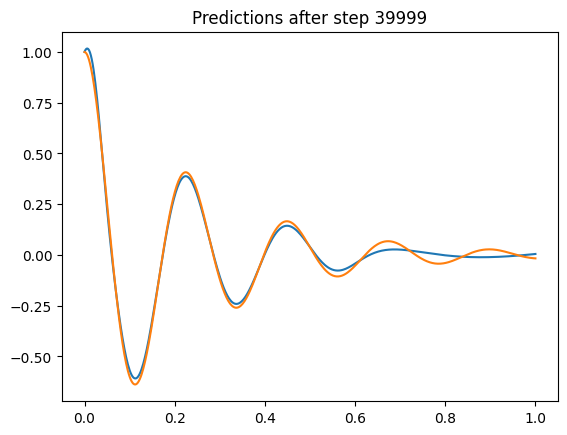

tensor(8.3252e-07, grad_fn=<MeanBackward0>) tensor(32.3414, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


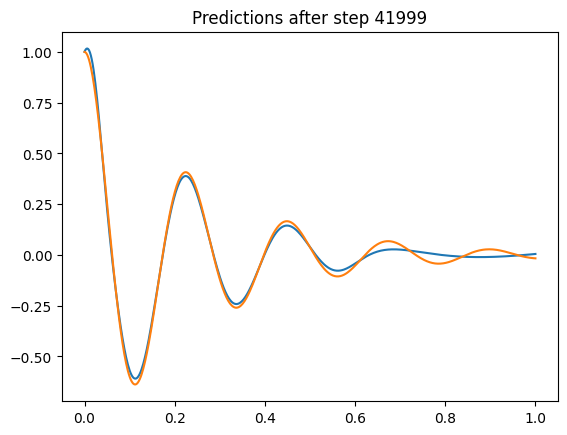

tensor(1.3059e-06, grad_fn=<MeanBackward0>) tensor(37.0238, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


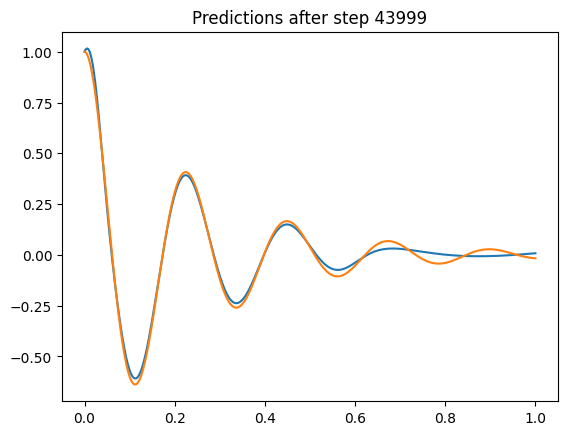

tensor(6.5537e-07, grad_fn=<MeanBackward0>) tensor(30.8120, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


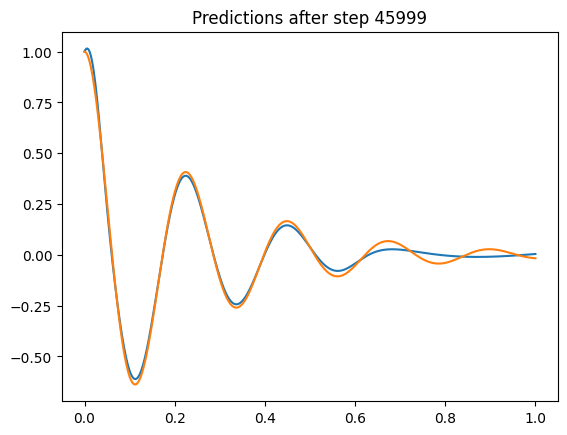

tensor(8.1672e-07, grad_fn=<MeanBackward0>) tensor(30.4184, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


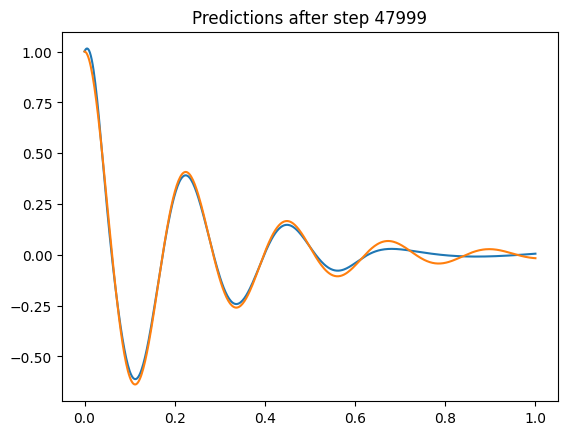

tensor(6.6079e-07, grad_fn=<MeanBackward0>) tensor(29.8079, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


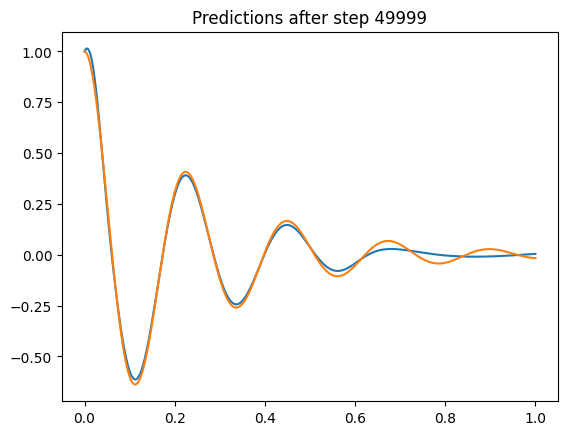

tensor(4.4311e-07, grad_fn=<MeanBackward0>) tensor(29.0337, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


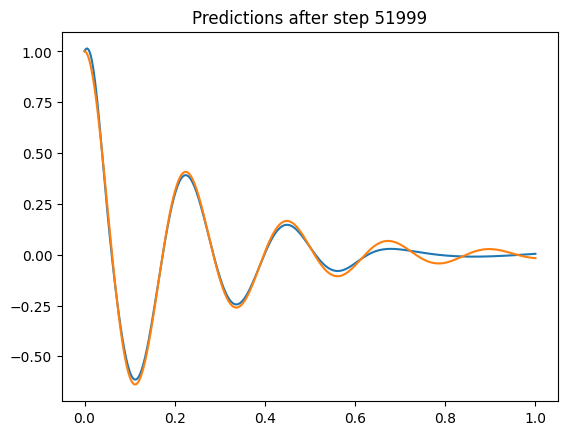

tensor(1.9122e-08, grad_fn=<MeanBackward0>) tensor(28.5621, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


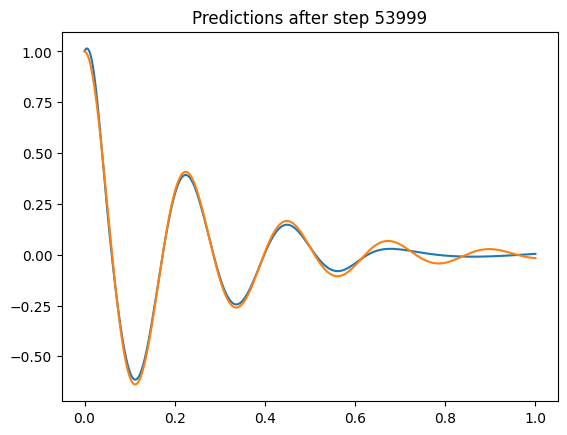

tensor(3.7486e-07, grad_fn=<MeanBackward0>) tensor(27.8779, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


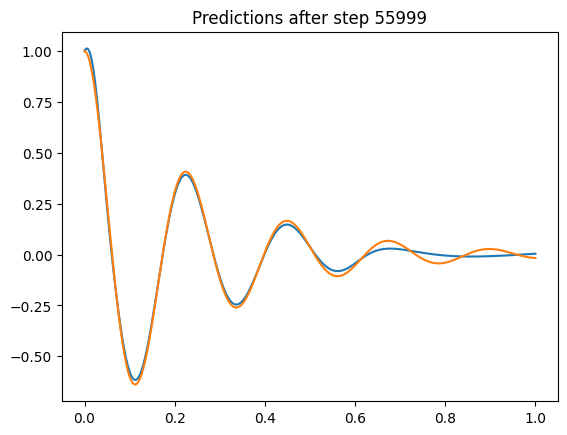

tensor(3.3828e-07, grad_fn=<MeanBackward0>) tensor(27.3719, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


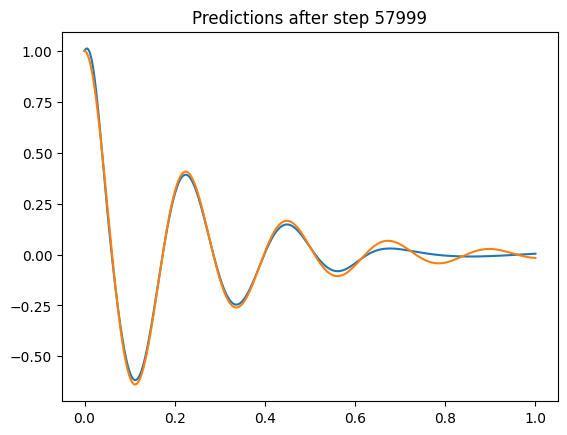

tensor(1.0694e-06, grad_fn=<MeanBackward0>) tensor(32.6280, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


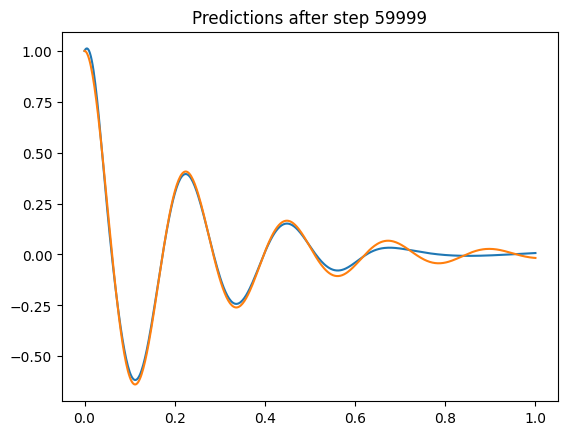

tensor(2.5020e-07, grad_fn=<MeanBackward0>) tensor(25.8853, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


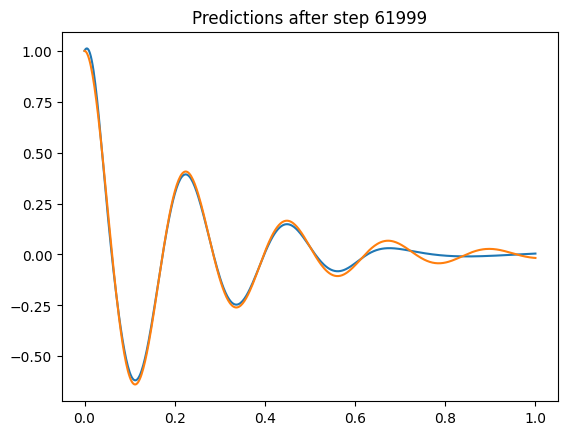

tensor(2.1383e-07, grad_fn=<MeanBackward0>) tensor(25.1160, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


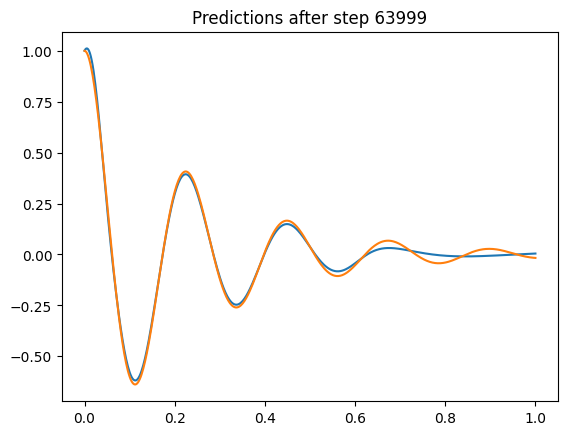

tensor(1.9099e-07, grad_fn=<MeanBackward0>) tensor(24.2833, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


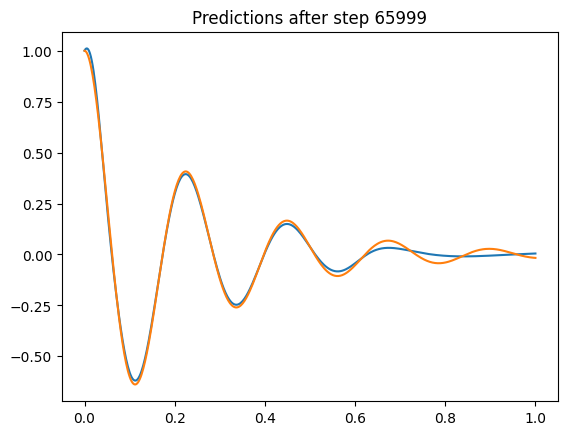

tensor(1.7329e-07, grad_fn=<MeanBackward0>) tensor(23.3919, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


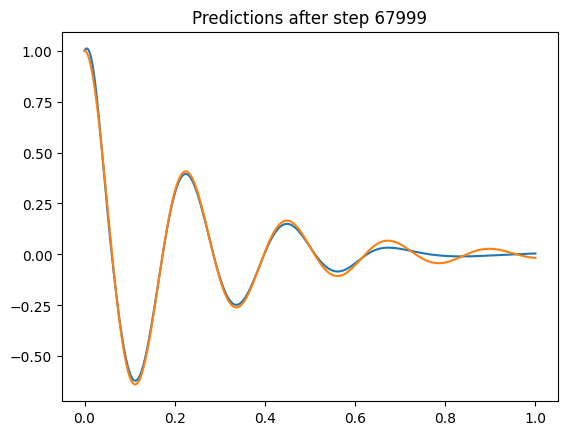

tensor(1.4380e-07, grad_fn=<MeanBackward0>) tensor(22.4656, grad_fn=<MeanBackward0>) tensor(9.5784e-05, grad_fn=<MeanBackward0>)


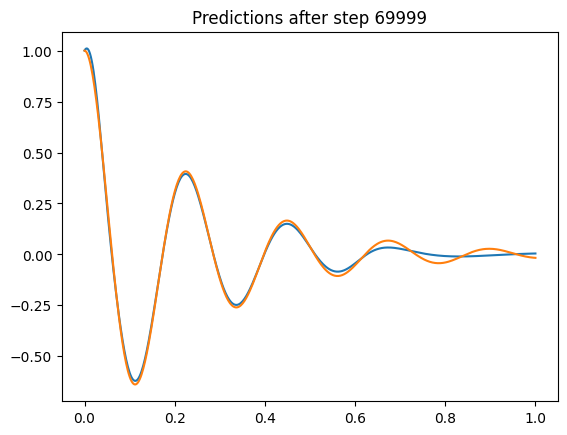

tensor(4.7115e-07, grad_fn=<MeanBackward0>) tensor(32.6910, grad_fn=<MeanBackward0>) tensor(8.2509e-05, grad_fn=<MeanBackward0>)


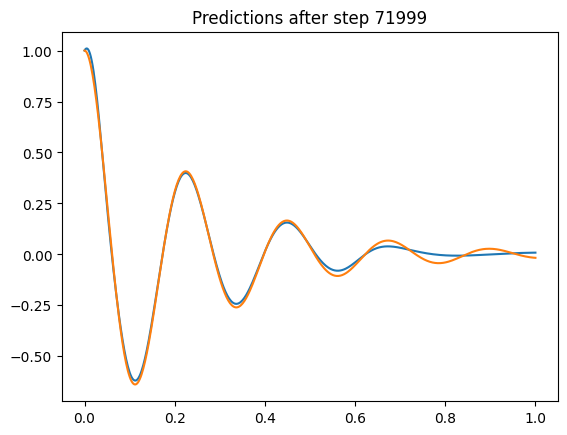

tensor(1.3376e-07, grad_fn=<MeanBackward0>) tensor(20.4527, grad_fn=<MeanBackward0>) tensor(8.2755e-05, grad_fn=<MeanBackward0>)


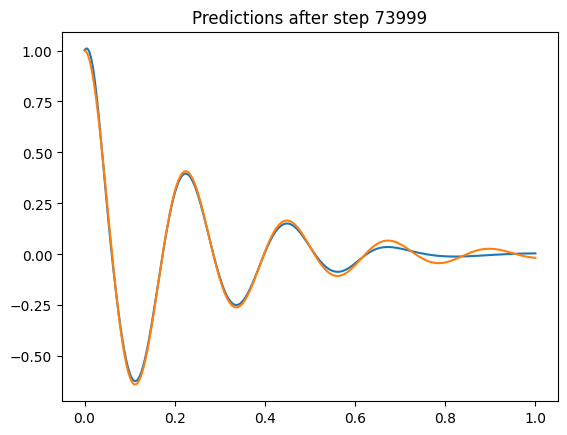

tensor(1.2117e-07, grad_fn=<MeanBackward0>) tensor(19.4714, grad_fn=<MeanBackward0>) tensor(7.6500e-05, grad_fn=<MeanBackward0>)


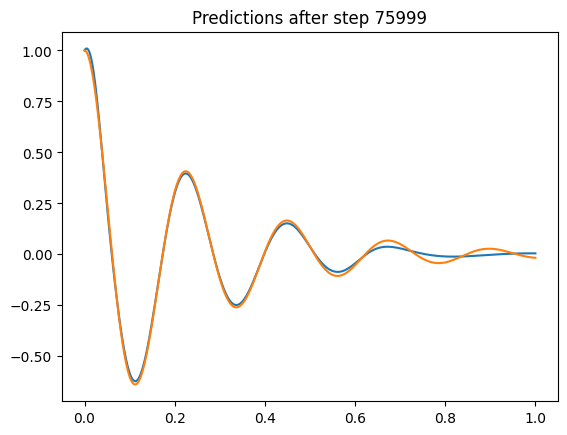

tensor(1.0337e-07, grad_fn=<MeanBackward0>) tensor(18.4859, grad_fn=<MeanBackward0>) tensor(7.1703e-05, grad_fn=<MeanBackward0>)


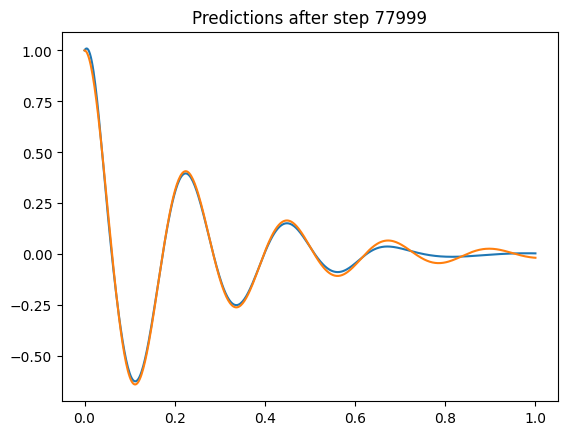

tensor(4.3836e-07, grad_fn=<MeanBackward0>) tensor(23.4425, grad_fn=<MeanBackward0>) tensor(6.1872e-05, grad_fn=<MeanBackward0>)


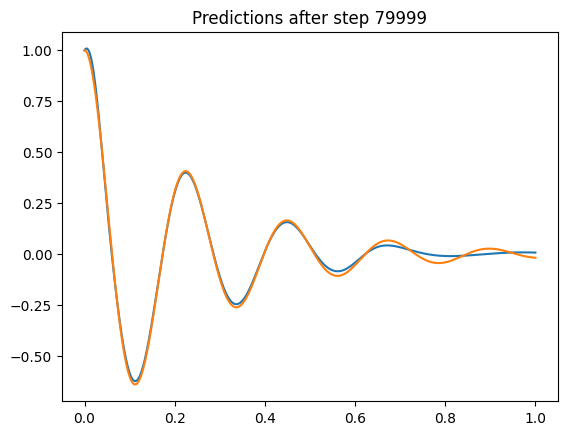

tensor(3.8783e-08, grad_fn=<MeanBackward0>) tensor(17.7474, grad_fn=<MeanBackward0>) tensor(6.8033e-05, grad_fn=<MeanBackward0>)


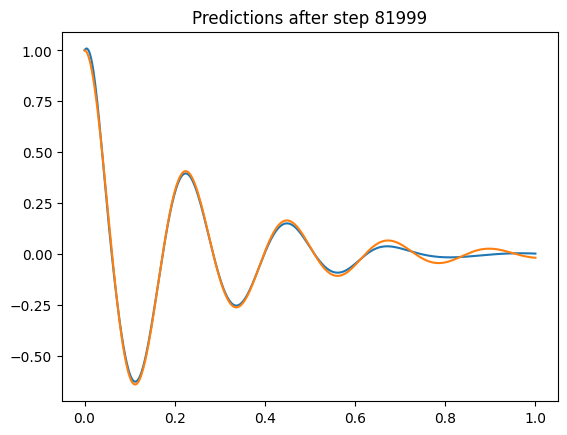

tensor(1.0607e-07, grad_fn=<MeanBackward0>) tensor(15.9276, grad_fn=<MeanBackward0>) tensor(5.7889e-05, grad_fn=<MeanBackward0>)


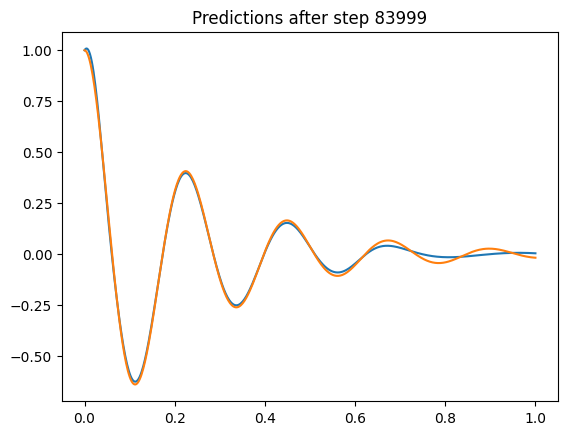

tensor(1.0199e-07, grad_fn=<MeanBackward0>) tensor(15.2208, grad_fn=<MeanBackward0>) tensor(5.4183e-05, grad_fn=<MeanBackward0>)


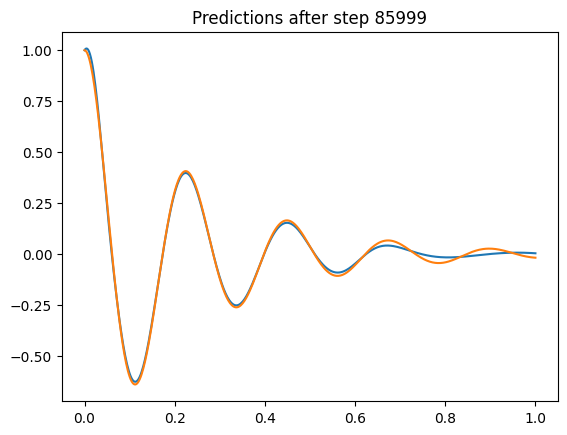

tensor(1.1141e-07, grad_fn=<MeanBackward0>) tensor(14.5868, grad_fn=<MeanBackward0>) tensor(5.1316e-05, grad_fn=<MeanBackward0>)


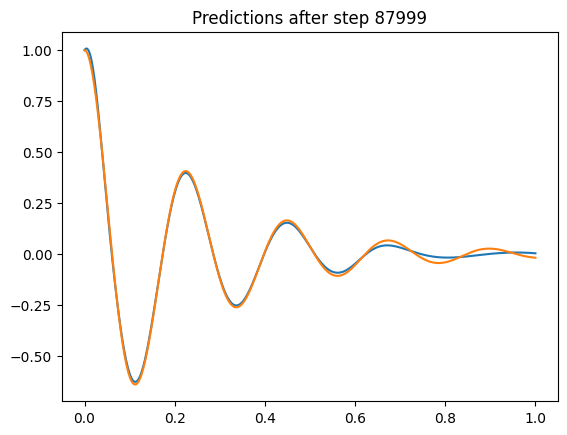

tensor(6.9848e-08, grad_fn=<MeanBackward0>) tensor(14.8632, grad_fn=<MeanBackward0>) tensor(4.5560e-05, grad_fn=<MeanBackward0>)


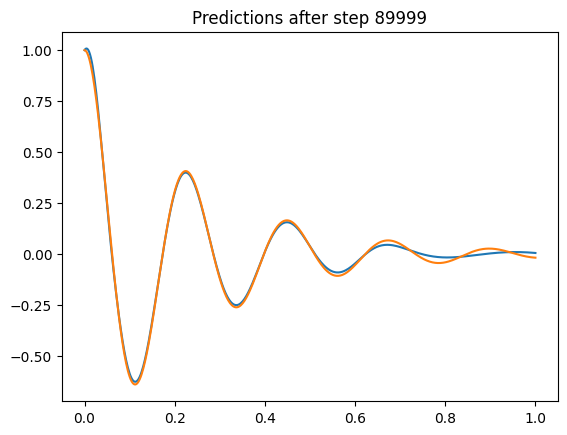

tensor(1.0583e-07, grad_fn=<MeanBackward0>) tensor(13.5729, grad_fn=<MeanBackward0>) tensor(4.5174e-05, grad_fn=<MeanBackward0>)


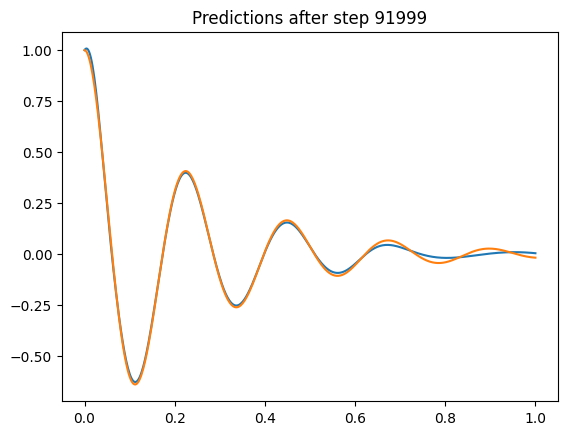

tensor(1.1133e-07, grad_fn=<MeanBackward0>) tensor(13.1911, grad_fn=<MeanBackward0>) tensor(4.2869e-05, grad_fn=<MeanBackward0>)


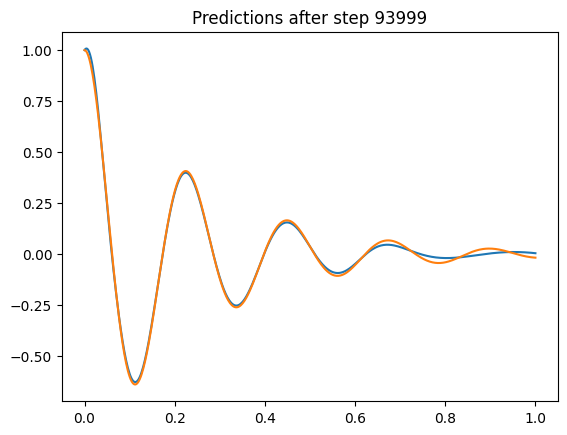

tensor(7.0431e-07, grad_fn=<MeanBackward0>) tensor(34.5875, grad_fn=<MeanBackward0>) tensor(4.5864e-05, grad_fn=<MeanBackward0>)


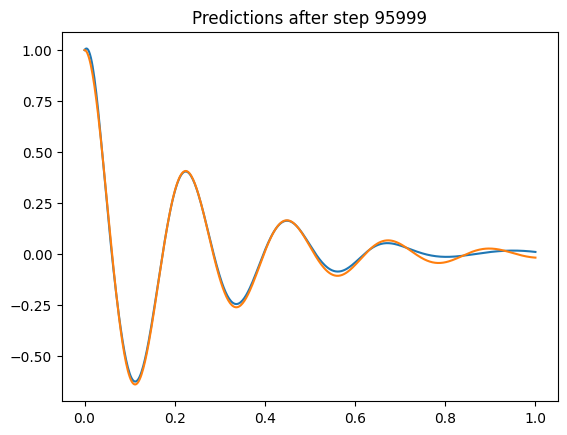

tensor(1.1656e-07, grad_fn=<MeanBackward0>) tensor(12.6117, grad_fn=<MeanBackward0>) tensor(3.8998e-05, grad_fn=<MeanBackward0>)


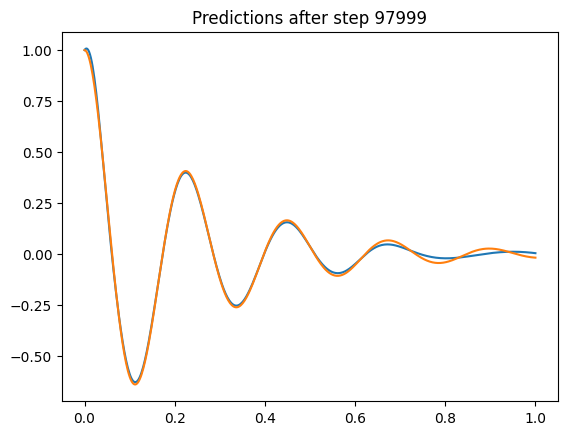

tensor(8.1991e-08, grad_fn=<MeanBackward0>) tensor(12.7476, grad_fn=<MeanBackward0>) tensor(4.0215e-05, grad_fn=<MeanBackward0>)


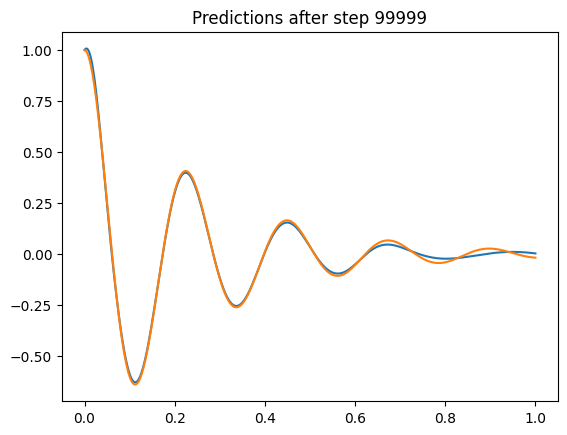

In [6]:
physics_xs = torch.linspace(0, 1.0, 30).view(-1, 1).requires_grad_(True)

data_x = x_data
data_y = y_data

mu, k = 2*d, w0**2


torch.manual_seed(123)
model = FullyConnected(1, 32, 1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-3)

for i in range(100000):
  optimizer2.zero_grad()

  # data loss
  pred_y = model(data_x)
  data_loss = torch.mean((pred_y - data_y) ** 2) # Mean squared error

  # physics loss
  physics_pred_y = model(physics_xs)
  dx = torch.autograd.grad(physics_pred_y, physics_xs, torch.ones_like(physics_pred_y), create_graph=True)[0]
  dx2 = torch.autograd.grad(dx, physics_xs, torch.ones_like(dx), create_graph=True)[0]
  residual = dx2 + mu * dx + k * physics_pred_y

  physics_loss = torch.mean(residual**2)

  # boundary conditions loss
  t_boundary = torch.zeros(1, requires_grad=True) # torch.tensor([0])
  x_boundary = torch.ones(1, requires_grad=True) #torch.tensor([1])
  # dx_boundary = torch.zeros(1, requires_grad=True) #torch.tensor([0])
  x0_predicted = model(t_boundary)
  dx_predicted = torch.autograd.grad(x0_predicted, t_boundary, torch.ones_like(t_boundary), create_graph=True)[0]
  residual_x0 = x0_predicted - x_boundary
  # residual_dx = dx_predicted
  boundary_loss = torch.mean(residual_x0 ** 2) #+ torch.mean(residual_dx ** 2)

  # boundary_conditions_loss =

  loss = boundary_loss + (1e-4) * physics_loss + data_loss #data_loss + (1e-6)*physics_loss
  loss.backward()
  optimizer2.step()

  if (i+1) % 2000 == 0:
    detached_t = physics_xs.detach()
    print(boundary_loss, physics_loss, data_loss)
    pred_ys = model(x).detach()
    plt.plot(x, pred_ys)
    plt.plot(x, y)
    # plt.scatter(detached_t, torch.zeros_like(detached_t))
    #plt.scatter(short_input_time, short_output_displacement)
    plt.title('Predictions after step '+str(i))
    plt.show()
